In [80]:
import sqlite3

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

“个人关系组成之集合体的概念化，提供历史学家评估古人于何时、如何，及为何利用亲族与非亲族关系。 社会网络关系分析家发现，人们须从不同的社会关系中、不同的人身上，寻求情绪上与经济上的支持。 因此，仅研究人们如何于危机时刻利用亲族关系已不足够；相反地，历史学的研究必须涵盖过去人们如何为不同目的而利用亲族与朋友关系，以及此一利用关系的优势与限制。 事实上，社会网络关系做为一种研究方法不仅有助于此一论辩，更帮助历史学家 Charles Tilly 所提出的挑战：将平民百姓的日常生活与大规模的社会变迁作有意义的链接。 ” Charles Wetherell 



从苏轼及其亲友的往来书信中归纳出社交网络关系（“朋友圈”），然后借助 networkx 对其社交网络关系进行可视化和分析

In [81]:
import warnings

warnings.filterwarnings('ignore')

In [82]:
db='data/cbdb_sqlite.db'

In [83]:
# 查找 person_id 函数
def getPersonId(person_name):
    ''' Get person_id
    @param person_name: str
    @return person_id: str
    '''
    sql = '''
    SELECT c_personid
    FROM biog_main
    WHERE c_name_chn = '{0}'
    '''.format(person_name)

    try:
        person_id = str(pd.read_sql(sql, con=sqlite3.connect(db)).iloc[0, 0])
        return person_id
    except:
        print("No such person.")

In [84]:
# 查找苏轼的 person_id，注意要使用繁体中文
person_id = getPersonId('王安石')
# 打印 person_id
print(person_id)

1762


In [85]:
sql = '''
SELECT a.c_personid person_id
    , b1.c_name_chn person_a
    , c_assoc_id assoc_id
    , b2.c_name_chn person_b
    , a.c_assoc_code assoc_code
    , c.c_assoc_desc_chn assoc_desc
FROM assoc_data a
LEFT JOIN biog_main b1 
    ON a.c_personid = b1.c_personid
LEFT JOIN biog_main b2 
    ON a.c_assoc_id = b2.c_personid
LEFT JOIN assoc_codes c 
    ON a.c_assoc_code = c.c_assoc_code
WHERE (a.c_personid = {0}
    OR a.c_personid IN (
        SELECT c_personid 
        FROM assoc_data 
        WHERE c_assoc_id = {0}
        AND c_assoc_code IN ('429', '430', '431', '432', '433', '434', '435', '436'))
    OR a.c_assoc_id IN (
        SELECT c_assoc_id
        FROM assoc_data 
        WHERE c_personid = {0}
        AND c_assoc_code IN ('429', '430', '431', '432', '433', '434', '435', '436'))) 
    AND a.c_assoc_code IN ('429', '430', '431', '432', '433', '434', '435', '436')
'''.format(person_id)

person_assoc = pd.read_sql(sql, con=sqlite3.connect(db))

In [86]:
# 查看 DataFrame 信息
person_assoc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921 entries, 0 to 1920
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   person_id   1921 non-null   int64 
 1   person_a    1921 non-null   object
 2   assoc_id    1921 non-null   int64 
 3   person_b    1921 non-null   object
 4   assoc_code  1921 non-null   int64 
 5   assoc_desc  1921 non-null   object
dtypes: int64(3), object(3)
memory usage: 90.2+ KB


In [87]:
person_assoc.head()

person_id person_a  assoc_id person_b  assoc_code assoc_desc
0         13      晁補之      1960       吳充         429        致書Y
1         13      晁補之      3767       蘇軾         429        致書Y
2         13      晁補之      3767       蘇軾         429        致書Y
3         13      晁補之      3767       蘇軾         429        致書Y
4         13      晁補之      3767       蘇軾         429        致書Y

In [88]:
person_assoc[(person_assoc['person_id'] == int(person_id)) | (person_assoc['assoc_id'] == int(person_id))].count()

person_id     224
person_a      224
assoc_id      224
person_b      224
assoc_code    224
assoc_desc    224
dtype: int64

In [89]:
# 打印所有关系的名称
for i in person_assoc['assoc_desc'].unique():
    print(i)

致書Y
被致書由Y
答Y書
收到Y的答書
致Y啓
收到Y的啓
答Y啓
收到Y的答啓


In [90]:
# 生成图
person_G = nx.from_pandas_edgelist(person_assoc, source='person_a', target='person_b', edge_attr='assoc_desc')

In [91]:
# 打印图信息
print(nx.info(person_G))
print('Density: {0}'.format(nx.density(person_G)))

Name: 
Type: Graph
Number of nodes: 441
Number of edges: 647
Average degree:   2.9342
Density: 0.006668728097299526


In [92]:
person_betweenness = pd.Series(nx.betweenness_centrality(person_G), name='Betweenness')
person_person = pd.Series.to_frame(person_betweenness)
person_person['Closeness'] = pd.Series(nx.closeness_centrality(person_G))
person_person['PageRank'] = pd.Series(nx.pagerank_scipy(person_G))
person_person['Degree'] = pd.Series(dict(nx.degree(person_G)))
desc_betweenness = person_person.sort_values('Betweenness', ascending=False)
desc_betweenness.head(10)

Betweenness  Closeness  PageRank  Degree
蘇軾      0.646066   0.637681  0.172926     211
歐陽修     0.400325   0.585106  0.098570     141
王安石     0.248573   0.549313  0.051482      79
司馬光     0.104487   0.506329  0.028768      41
富弼      0.035679   0.482986  0.011631      19
韓維      0.030687   0.413923  0.013903      22
曾鞏      0.025728   0.476706  0.010260      16
張方平     0.024361   0.477223  0.010945      18
文彥博     0.023790   0.490524  0.011295      19
呂惠卿     0.014513   0.360360  0.006110       9

In [93]:
#pos = nx.circular_layout(person_G)
pos = nx.kamada_kawai_layout(person_G)
#pos = nx.shell_layout(person_G)
#pos = nx.spring_layout(person_G)
#pos = nx.random_layout(person_G)

In [94]:
# 绘制函数
def draw_graph(df, top):
    ''' Draw Graph
    @param df: DataFrame
    @param top: int, numbers of top
    '''    
    nodes = df.index.values.tolist() #生成节点列表
    edges = nx.to_edgelist(person_G) #生成边列表
    # 生成无向度量图
    metric_G = nx.Graph()
    metric_G.add_nodes_from(nodes)
    metric_G.add_edges_from(edges)
    # 生成 Top n 的标签列表
    top_labels = {}
    for node in nodes[:top]:
        top_labels[node] = node
    # 生成节点尺寸列表
    node_sizes = []
    for node in nodes:
            node_sizes.append(df.loc[node]['Degree'] * 16 ** 2)
    # 设置图形尺寸
    plt.figure(1, figsize=(64, 64))
    # 绘制图形
    nx.draw(metric_G, pos=pos, node_color='#cf1322', with_labels=False)
    nx.draw_networkx_nodes(metric_G, pos=pos, nodelist=nodes[:top], node_color='#a8071a', node_size=node_sizes[:top])
    nx.draw_networkx_nodes(metric_G, pos=pos, nodelist=nodes[top:], node_color='#a3b1bf', node_size=node_sizes[top:])
    nx.draw_networkx_edges(metric_G, pos=pos, edgelist=edges, edge_color='#d9d9d9', arrows=False)
    nx.draw_networkx_labels(metric_G, pos=pos, font_size=20, font_color='#555555')
    nx.draw_networkx_labels(metric_G, pos=pos, labels=top_labels, font_size=28, font_color='#1890ff')
    # 保存图片
    plt.savefig('tmp.png')

In [95]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

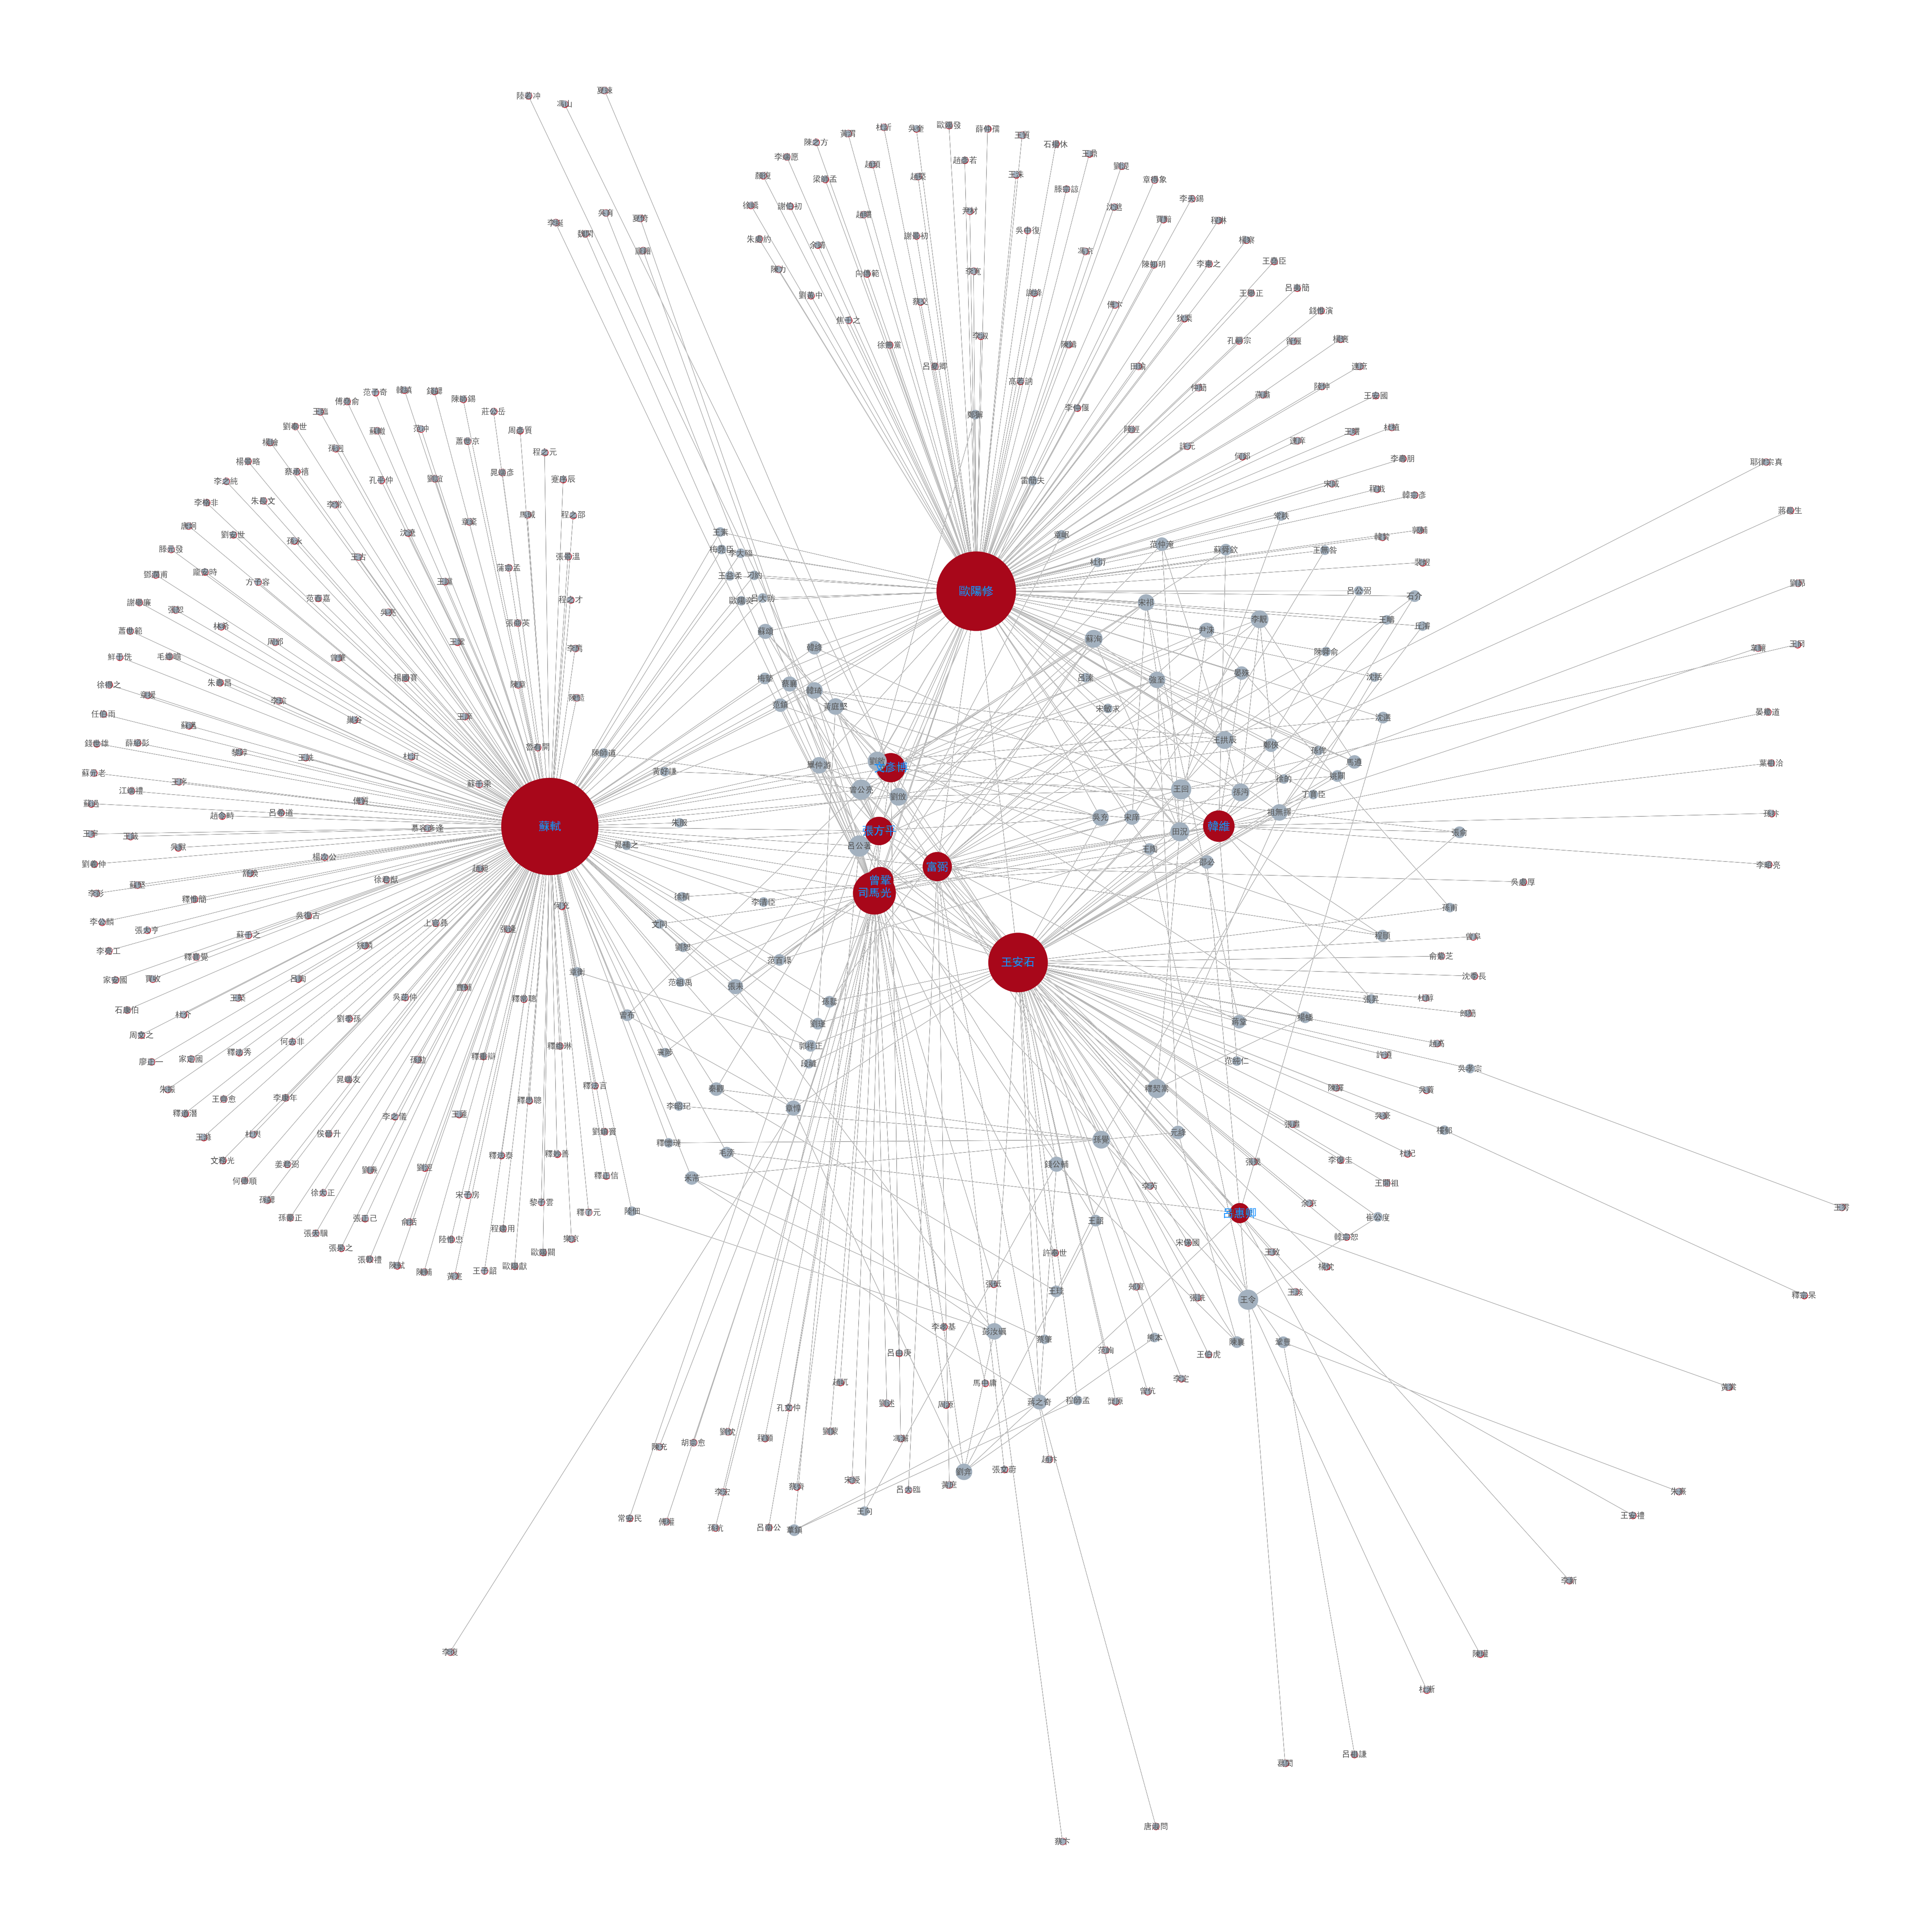

In [96]:
draw_graph(desc_betweenness, 10)